In [109]:
%load_ext autoreload
%autoreload 2

import os
import random
import json
from pathlib import Path

# Evaluation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader

from sign_language_model.dataset import WLASLDataset
from sign_language_model.utils import set_seed


set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [153]:
DATA_DIR = Path(os.getcwd()).parent / "data" / "wlasl_reduced"
TENSOR_ROOT = DATA_DIR / "tensors" / "kps"

In [154]:
train_ds = WLASLDataset(
    npz_path=DATA_DIR / "tensors" / "kps" / "train.npz",
    augment_kps=True,
    gloss_map_path=DATA_DIR / "gloss_map.json",
)
test_ds = WLASLDataset(
    npz_path=DATA_DIR / "tensors" / "kps" / "test.npz",
    augment_kps=False,
    gloss_map_path=DATA_DIR / "gloss_map.json",
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [155]:
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=100,
    gradient_clip=False,
    ckpt_path=None,
    min_delta=1e-4,
    patience=15,
):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        # =====================
        # Training
        # =====================
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()

            batch_x_kps = batch_x["kps"].to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x_kps)
            loss = criterion(outputs, batch_y)
            loss.backward()

            if gradient_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            total_loss += loss.item() * batch_x_kps.size(0)
            correct += (outputs.argmax(1) == batch_y).sum().item()
            total += batch_y.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # =====================
        # Validation
        # =====================
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x_kps = batch_x["kps"].to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_x_kps)
                loss = criterion(outputs, batch_y)

                val_loss_sum += loss.item() * batch_x_kps.size(0)
                val_correct += (outputs.argmax(1) == batch_y).sum().item()
                val_total += batch_y.size(0)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # =====================
        # Checkpoint logic
        # =====================
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0

            if ckpt_path is not None:
                torch.save(model.state_dict(), ckpt_path)
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch + 1}/{epochs}] "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Train Acc: {train_acc:.4f} | "
                f"Val Acc: {val_acc:.4f}"
            )

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_losses, val_losses, train_accs, val_accs

In [156]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    preds, labels = [], []
    loss_sum, total = 0.0, 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x_kps = batch_x["kps"].to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x_kps)
            loss = criterion(outputs, batch_y)

            loss_sum += loss.item() * batch_x_kps.size(0)
            total += batch_y.size(0)

            preds.append(outputs.argmax(1).cpu().numpy())
            labels.append(batch_y.cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    acc = (preds == labels).mean()
    avg_loss = loss_sum / total

    return avg_loss, acc, preds, labels

In [267]:
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        # in: (B, C, T, V) = (batch, channels, time_steps, features)
        # reshape to (B, T, V*C)
        B, C, T, V = x.size()
        x = x.permute(0, 2, 3, 1).contiguous().view(B, T, V * C)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x


class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, T, H)
        weights = torch.softmax(self.attn(x), dim=1)
        return (weights * x).sum(dim=1)


class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3,
        )
        self.attn = TemporalAttention(hidden_size * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        # in: (B, C, T, V) = (batch, channels, time_steps, features)
        # reshape to (B, T, V*C)
        B, C, T, V = x.size()
        x = x.permute(0, 2, 3, 1).contiguous().view(B, T, V * C)
        x, _ = self.lstm(x)
        x = self.attn(x)
        return self.fc(x)


class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # in: (B, C, T, V) = (batch, channels, time_steps, features)
        # reshape to (B, T, V*C) = (B, 32, 75*3)
        B, C, T, V = x.size()
        x = x.permute(0, 2, 3, 1).contiguous().view(B, T, V * C)
        x = x.mean(dim=1)  # global average pooling over time
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=32):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, T, D)

    def forward(self, x):
        return x + self.pe[:, : x.size(1)]


class TemporalAttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, T, D)
        weights = torch.softmax(self.attn(x), dim=1)
        return (weights * x).sum(dim=1)


class TransformerEncoderKeypointsModel(nn.Module):
    def __init__(self, num_classes, T=32, V=75, C=3, d_model=128):
        super().__init__()

        self.joint_embed = nn.Linear(C, 16)
        self.temporal_proj = nn.Linear(16 * V, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=32)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=2,
            dim_feedforward=256,
            dropout=0.3,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, 2)

        self.pool = TemporalAttentionPooling(d_model)

        self.fc = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        B, C, T, V = x.shape
        x = x.permute(0, 2, 3, 1)  # (B, T, V, C)
        x = self.joint_embed(x)  # (B, T, V, 16)
        x = x.reshape(B, T, -1)  # (B, T, V*16)
        x = self.temporal_proj(x)  # (B, T, d_model)

        x = self.pos_enc(x)  # (B, T, d_model)
        x = self.encoder(x)  # (B, T, d_model)
        x = self.pool(x)  # (B, d_model)
        return self.fc(x)


In [268]:
input_size = train_ds[0][0]["kps"].shape[2] * train_ds[0][0]["kps"].shape[0]  # V * C
num_classes = len(train_ds.label_to_index)

models = {
    # "BaselineLSTM": BaselineLSTM(
    #     input_size=input_size, hidden_size=128, num_classes=num_classes
    # ),
    # "BiLSTMWithAttention": BiLSTMWithAttention(
    #     input_size=input_size, hidden_size=128, num_classes=num_classes
    # ),
    "TransformerEncoderKeypointsModel": TransformerEncoderKeypointsModel(
        num_classes=num_classes, T=32, V=75, C=3, d_model=128
    ),
    # "MLPModel": MLPModel(input_size=input_size, num_classes=num_classes),
}

print(f"{input_size=}, {num_classes=}")
for model_name, model in models.items():
    print(
        f"Number of parameters in {model_name}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
    )

input_size=225, num_classes=35
Number of parameters in TransformerEncoderKeypointsModel: 423652


In [269]:
results = {}
for name, model in models.items():
    print(f"\n{'=' * 60}")
    print(f"Training {name}")
    print(f"{'=' * 60}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    n_epochs = 500

    ckpt_path = None

    train_loss, val_loss, train_acc, val_acc = train_model(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        epochs=n_epochs,
        gradient_clip=True,
        ckpt_path=ckpt_path,
        min_delta=1e-4,
        patience=n_epochs,
    )

    # Load best checkpoint
    if ckpt_path is not None:
        model.load_state_dict(torch.load(ckpt_path))

    test_loss, test_acc, preds, labels = evaluate_model(
        model,
        test_loader,
        criterion,
    )

    results[name] = {
        "model": model,
        "train_losses": train_loss,
        "val_losses": val_loss,
        "train_accs": train_acc,
        "val_accs": val_acc,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "y_pred": preds,
        "y_true": labels,
    }

    print(f"{name} — Test Accuracy: {test_acc:.4f}")


Training TransformerEncoderKeypointsModel
Epoch [10/500] Train Loss: 2.9310 | Val Loss: 3.0910 | Train Acc: 0.1766 | Val Acc: 0.1167
Epoch [20/500] Train Loss: 2.1280 | Val Loss: 2.6529 | Train Acc: 0.4491 | Val Acc: 0.2500
Epoch [30/500] Train Loss: 1.5861 | Val Loss: 2.7427 | Train Acc: 0.6737 | Val Acc: 0.2833
Epoch [40/500] Train Loss: 1.2739 | Val Loss: 2.9219 | Train Acc: 0.8204 | Val Acc: 0.3500
Epoch [50/500] Train Loss: 1.0792 | Val Loss: 2.8994 | Train Acc: 0.8922 | Val Acc: 0.3500
Epoch [60/500] Train Loss: 0.9593 | Val Loss: 2.8461 | Train Acc: 0.9222 | Val Acc: 0.3500
Epoch [70/500] Train Loss: 0.8999 | Val Loss: 2.7066 | Train Acc: 0.9551 | Val Acc: 0.4167
Epoch [80/500] Train Loss: 0.8671 | Val Loss: 2.7725 | Train Acc: 0.9701 | Val Acc: 0.3833
Epoch [90/500] Train Loss: 0.7801 | Val Loss: 2.6668 | Train Acc: 0.9940 | Val Acc: 0.4500
Epoch [100/500] Train Loss: 0.7943 | Val Loss: 2.6424 | Train Acc: 0.9820 | Val Acc: 0.4500
Epoch [110/500] Train Loss: 0.7458 | Val Loss:

In [270]:
def plot_loss_and_accuracy(
    train_losses, val_losses, train_accs, val_accs, title_prefix=""
):
    """
    Plot training & validation loss and accuracy side-by-side.

    Parameters
    ----------
    train_losses : list[float]
        Training loss per epoch
    val_losses : list[float]
        Validation loss per epoch
    train_accs : list[float]
        Training accuracy per epoch
    val_accs : list[float]
        Validation accuracy per epoch
    title_prefix : str
        Prefix for plot titles (e.g. 'first_30', 'uniform_30')
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # -----------------------
    # Loss curves
    # -----------------------
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Validation Loss")
    axes[0].set_title(f"{title_prefix} Loss Curves")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # -----------------------
    # Accuracy curves
    # -----------------------
    axes[1].plot(train_accs, label="Train Accuracy")
    axes[1].plot(val_accs, label="Validation Accuracy")
    axes[1].set_title(f"{title_prefix} Accuracy Curves")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

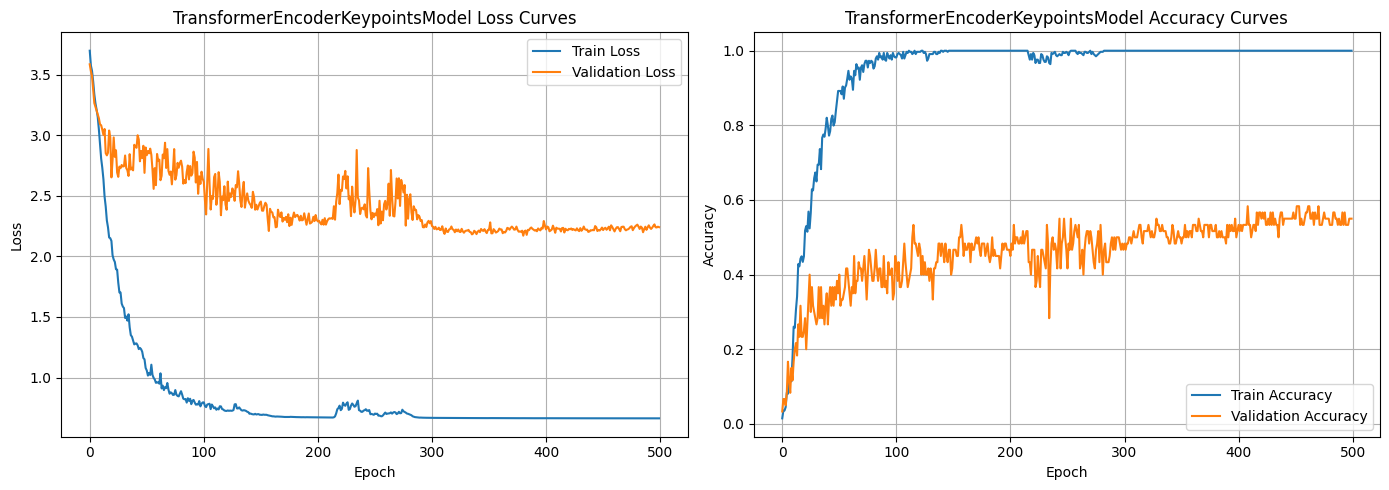

In [271]:
for model_name in results.keys():
    plot_loss_and_accuracy(
        results[model_name]["train_losses"],
        results[model_name]["val_losses"],
        results[model_name]["train_accs"],
        results[model_name]["val_accs"],
        title_prefix=model_name,
    )

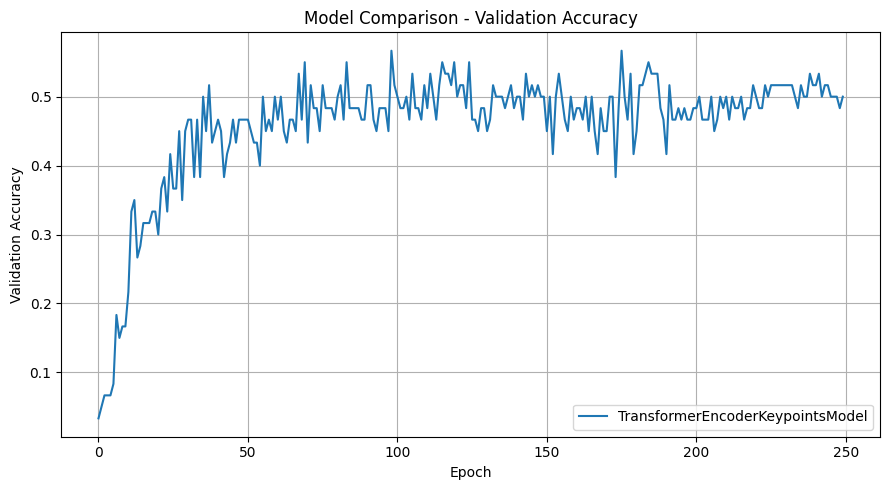

In [260]:
plt.figure(figsize=(9, 5))
for name, r in results.items():
    plt.plot(r["val_accs"], label=name)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison - Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

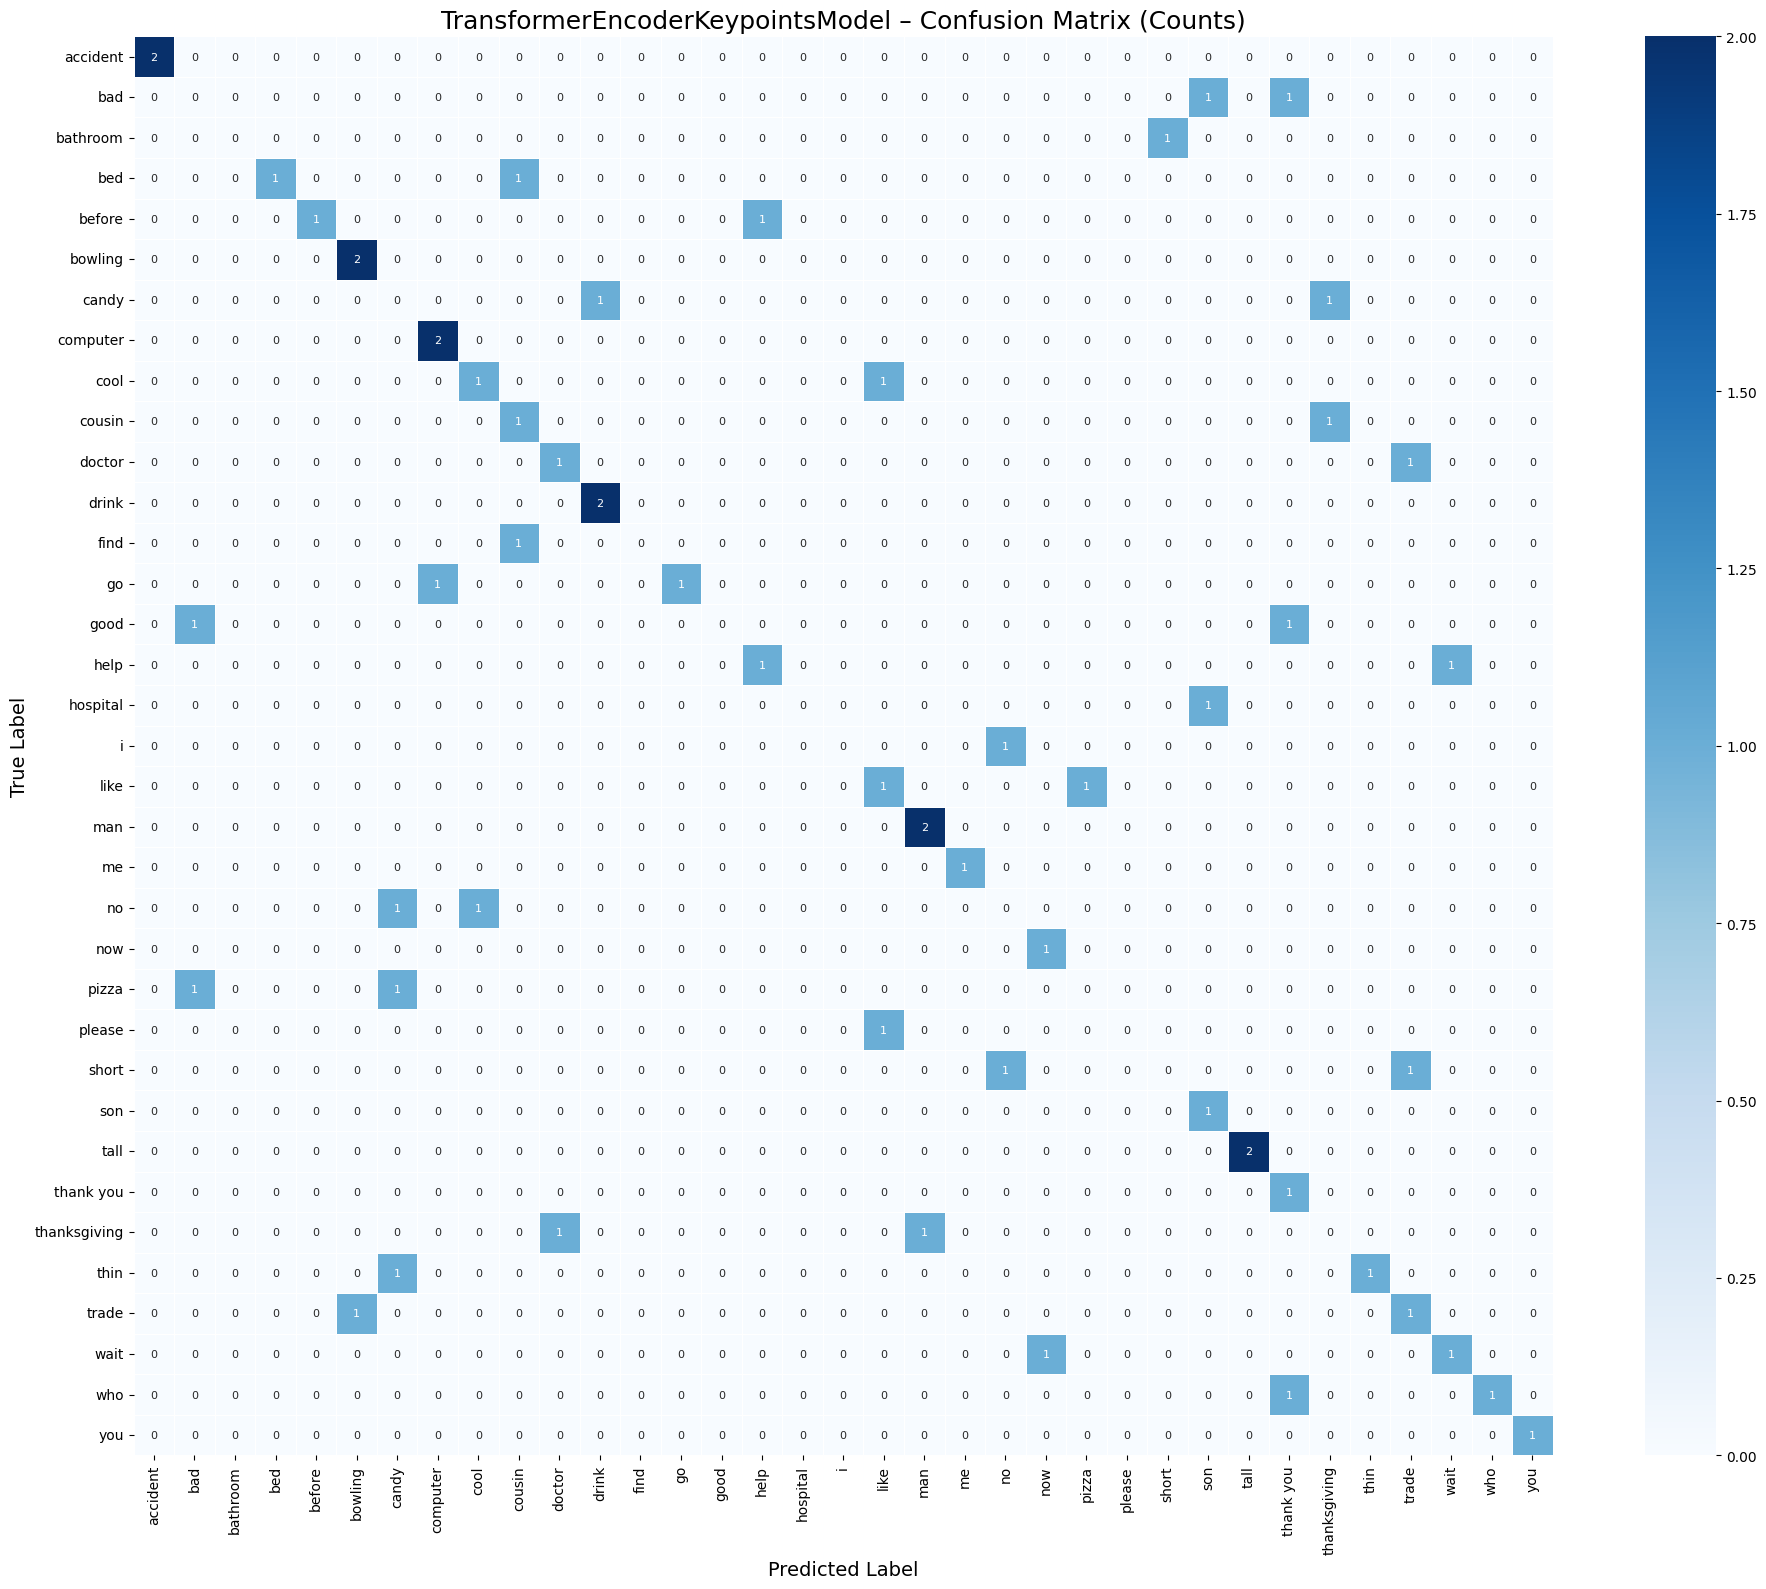

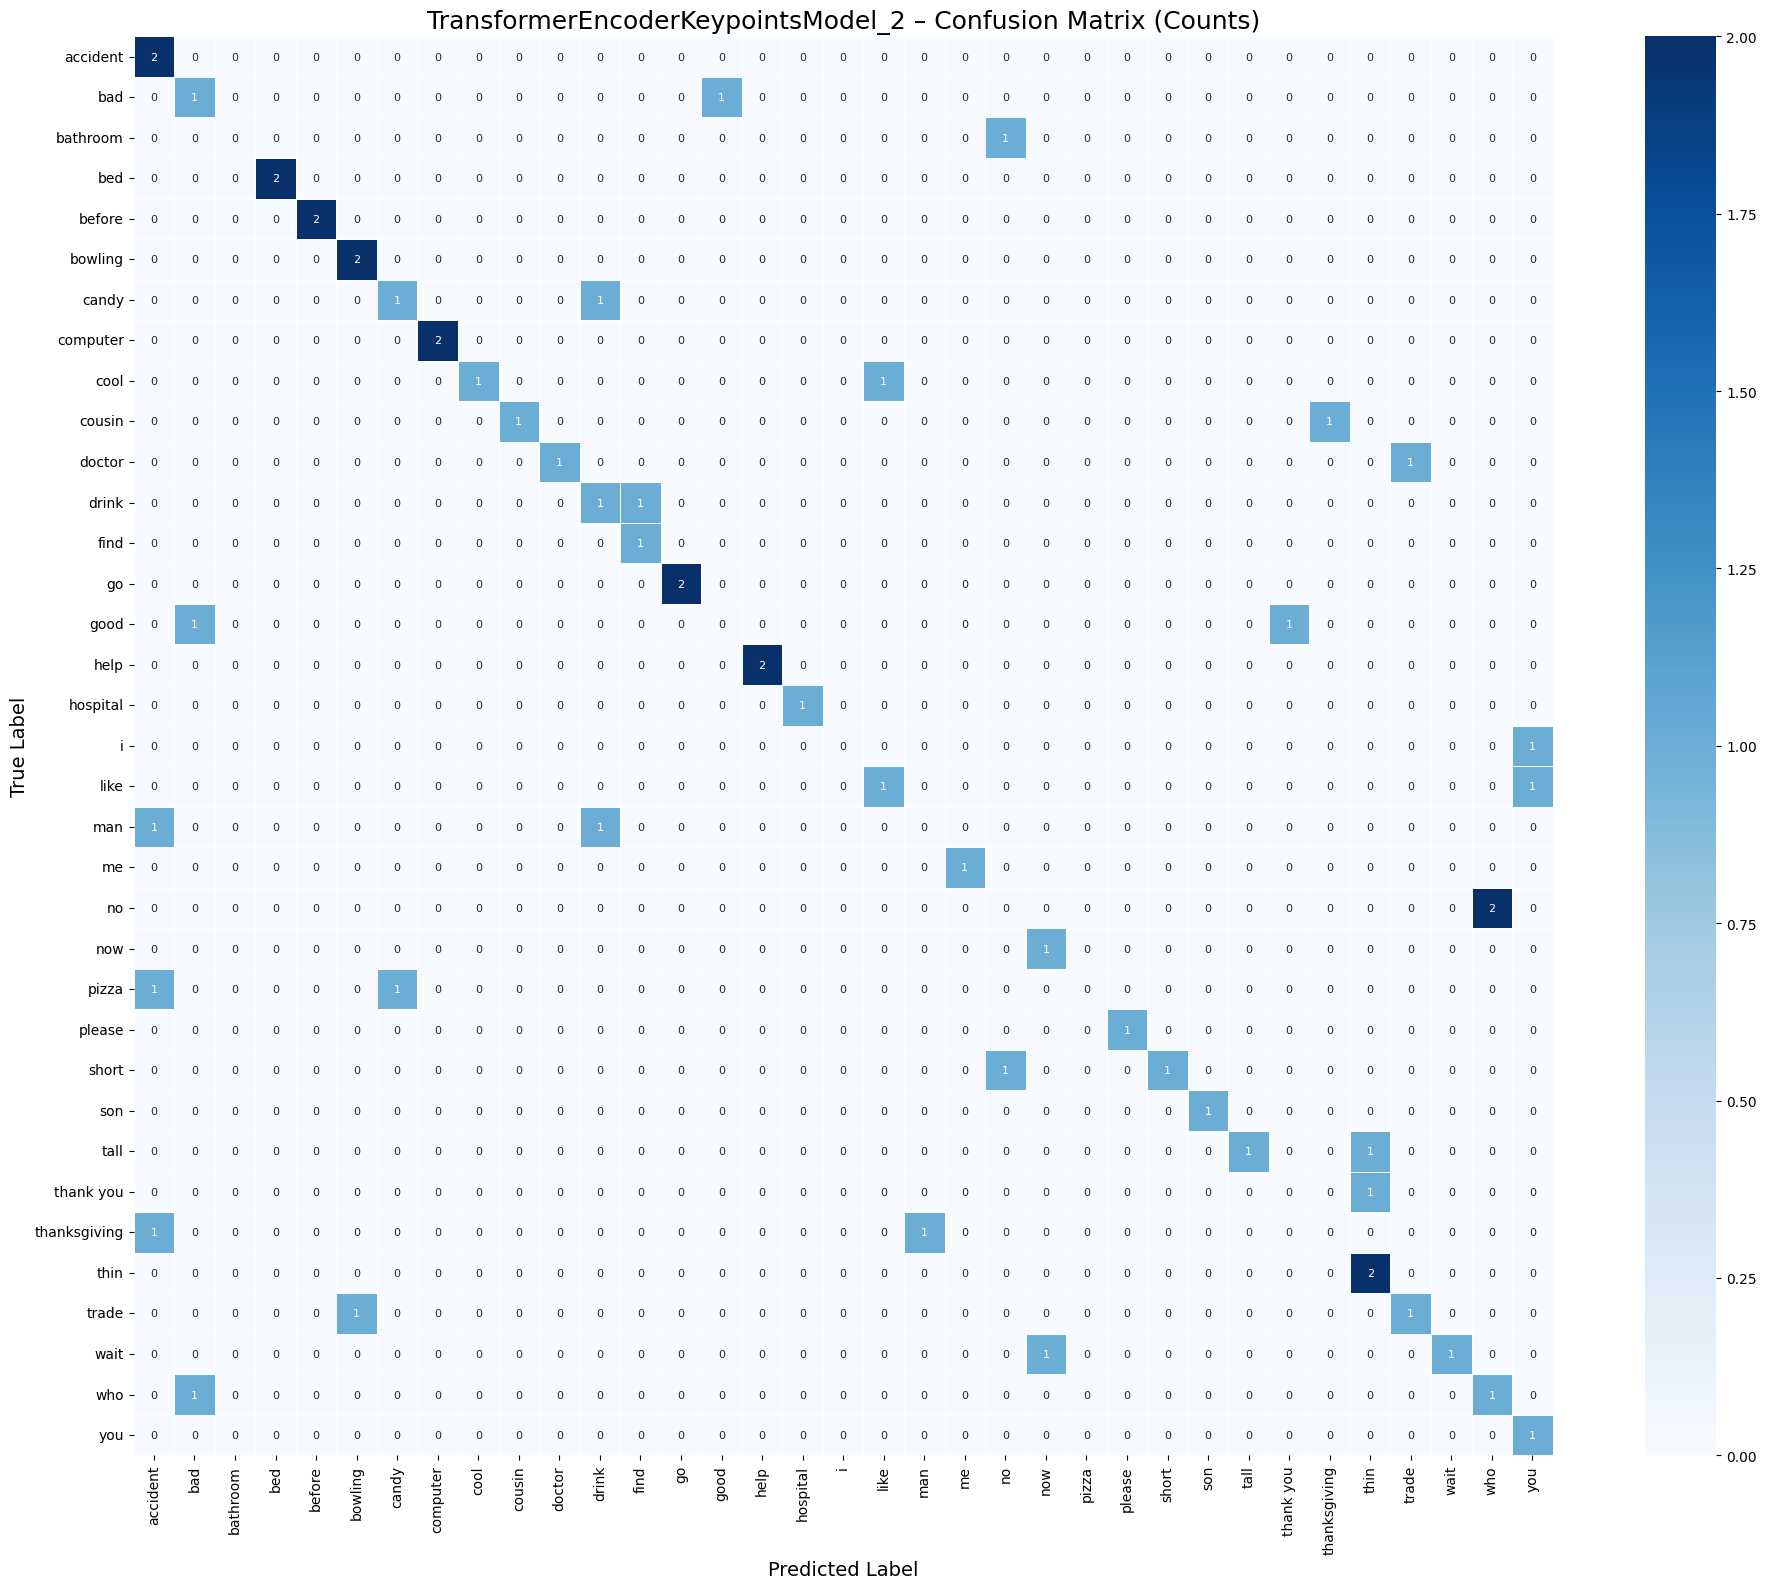

In [167]:
gloss2idx = json.load(open(DATA_DIR / "gloss_map.json"))
idx2gloss = {v: k for k, v in gloss2idx.items()}

for name, r in results.items():
    conf = confusion_matrix(
        r["y_true"], r["y_pred"], labels=list(range(len(gloss2idx)))
    )

    plt.figure(figsize=(20, 16))
    ax = sns.heatmap(
        conf,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=list(idx2gloss.values()),
        yticklabels=list(idx2gloss.values()),
        square=True,
        linewidths=0.5,
        annot_kws={"size": 8},  # <<< SMALLER TEXT
    )

    ax.set_title(f"{name} – Confusion Matrix (Counts)", fontsize=18)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)

    ax.tick_params(axis="x", labelrotation=90, labelsize=10)
    ax.tick_params(axis="y", labelrotation=0, labelsize=10)

    plt.tight_layout()
    plt.show()

In [152]:
summary = pd.DataFrame(
    [
        {
            "Model": name,
            "Test Loss": r["test_loss"],
            "Test Accuracy": r["test_accuracy"],
        }
        for name, r in results.items()
    ]
)
summary

,Model,Test Loss,Test Accuracy
0,BaselineLSTM,3.284445,0.183333
1,BiLSTMWithAttention,2.889721,0.400000
2,TransformerEncoderKeypointsModel,2.056399,0.516667
3,MLPModel,2.705118,0.500000
